In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from PIL import Image
import cv2

from pycocotools.coco import COCO

In [3]:
data_dir = "./input"
train_json = "densepose_coco_2014_train.json"

## JSON 파일 확인

In [4]:
with open(os.path.join(data_dir, train_json), "r") as f:
    dataset = json.load(f)

In [5]:
print(
    f"""
    keys : {dataset.keys()}\n
    annotations : {dataset['annotations'][0].keys()}\n
    length of annotations : {len(dataset['annotations'])}\n
    categories[0] : {dataset['categories'][0]}\n
    length of categories : {len(dataset['categories'])}\n
    images[0] : {dataset['images'][0]}\n
    length of images : {len(dataset['images'])}
"""
    )


    keys : dict_keys(['annotations', 'categories', 'images'])

    annotations : dict_keys(['area', 'bbox', 'category_id', 'dp_I', 'dp_U', 'dp_V', 'dp_masks', 'dp_x', 'dp_y', 'id', 'image_id', 'iscrowd', 'keypoints', 'num_keypoints', 'segmentation'])

    length of annotations : 100403

    categories[0] : {'id': 1, 'keypoints': ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'], 'name': 'person', 'skeleton': [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]], 'supercategory': 'person'}

    length of categories : 1

    images[0] : {'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000262145.jpg', 'date_captured': '2013-11-20 02:07:55', 'file_name': 'COCO_train2014_00000

In [36]:
dataset['annotations'][1]

{'area': 74.23865,
 'bbox': [494.31, 91.04, 11.7, 16.16],
 'category_id': 1,
 'id': 1220136,
 'image_id': 262145,
 'iscrowd': 0,
 'keypoints': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'num_keypoints': 0,
 'segmentation': [[505.24,
   98.89,
   505.4,
   96.89,
   505.7,
   95.04,
   506.01,
   93.65,
   505.7,
   91.81,
   504.78,
   91.04,
   502.16,
   91.04,
   501.24,
   91.96,
   501.09,
   93.19,
   500.93,
   94.73,
   498.47,
   96.89,
   497.39,
   98.12,
   496.16,
   101.04,
   495.24,
   103.81,
   494.31,
   107.2,
   499.24,
   102.12,
   501.39,
   101.2,
   503.09,
   100.58,
   505.09,
   99.35]]}

## images 부분 DataFrame 만들기

In [58]:
import pandas as pd

datalist = []
for row in dataset['images']:
    datalist.append({
        'image_id' : row['id'],
        'file_name' : row['file_name'],
        'height' : row['height'],
        'width' : row['width'],
    })

image_df = pd.DataFrame(datalist)

In [59]:
image_df.head()

,image_id,file_name,height,width
0,262145,COCO_train2014_000000262145.jpg,427,640
1,393224,COCO_train2014_000000393224.jpg,640,427
2,524297,COCO_train2014_000000524297.jpg,446,640
3,393227,COCO_train2014_000000393227.jpg,640,427
4,262146,COCO_train2014_000000262146.jpg,640,480


In [60]:
image_df.describe()

,image_id,height,width
count,26437.000000,26437.000000,26437.000000
mean,290831.681999,498.072399,569.629988
std,168315.392767,98.125729,96.354125
min,36.000000,160.000000,128.000000
25%,143811.000000,427.000000,480.000000
50%,292145.000000,480.000000,640.000000
75%,436544.000000,640.000000,640.000000
max,581921.000000,640.000000,640.000000


## annotations 부분 DataFrame 만들기

In [61]:
datalist = []
for row in dataset['annotations']:
    datalist.append({
        'image_id' : row['image_id'],
        'area' : row['area'],
        'bbox' : row['bbox'],
        'maskYN' : 'dp_masks' in row.keys()
    })

anns_df = pd.DataFrame(datalist)

In [62]:
anns_df.head()

,image_id,area,bbox,maskYN
0,262145,21258.00000,"[387, 71.1, 145, 322]",True
1,262145,74.23865,"[494.31, 91.04, 11.7, 16.16]",False
2,262145,2053.16515,"[282.37, 86.79, 32.16, 97.02]",False
3,262145,9110.87005,"[526.17, 44.14, 90.5, 188]",True
4,262145,1962.25295,"[491.51, 81.19, 40.46, 85.34]",False


In [99]:
anns_df.describe()

,image_id,area
count,100403.000000,100403.000000
mean,290970.875671,17363.405661
std,168473.948592,27873.264238
min,36.000000,2.337850
25%,142352.000000,1195.069625
50%,294850.000000,6066.359450
75%,437531.000000,21296.269875
max,581921.000000,374686.741100


In [88]:
anns_df[anns_df['image_id'] == 262145]

,image_id,area,bbox,maskYN
0,262145,21258.00000,"[387, 71.1, 145, 322]",True
1,262145,74.23865,"[494.31, 91.04, 11.7, 16.16]",False
2,262145,2053.16515,"[282.37, 86.79, 32.16, 97.02]",False
3,262145,9110.87005,"[526.17, 44.14, 90.5, 188]",True
4,262145,1962.25295,"[491.51, 81.19, 40.46, 85.34]",False
5,262145,286.98170,"[477.88, 87.8, 13.7, 33.4]",False
6,262145,5700.34200,"[308.98, 76.76, 49.89, 148.73]",False
7,262145,4953.06355,"[71.97, 104.59, 59.49, 144.89]",False
8,262145,439.47295,"[352.59, 136.15, 28.15, 30.84]",False
9,262145,357.13205,"[52.18, 98.34, 21.89, 33.75]",False


## 이미지 bbox 확인하기 
- mask O : 빨간색 박스
- mask X : 푸른색 박스

- 내 생각 : mask 존재하지 않는 부분은 아예 지우면 모델이 더 확실하게 학습 가능하지 않을까??

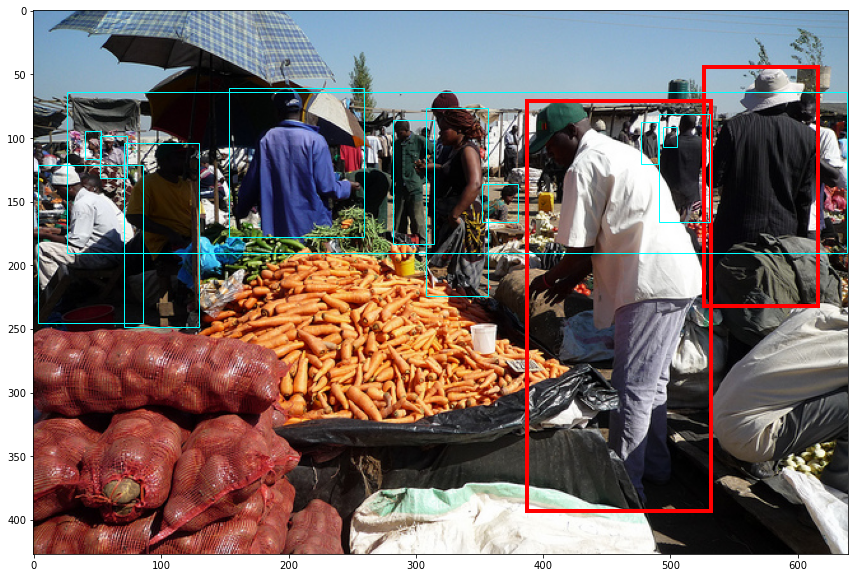

In [97]:
from PIL import Image
import matplotlib.patches as patches
from random import randint
import os

# random으로 이미지 뽑는 경우
# rand_img_file = image_df.iloc[randint(0, len(image_df))]

# 원하는 이미지 index로 선택할 경우
rand_img_file = image_df.iloc[0]

rand_id, rand_file_name = rand_img_file['image_id'], rand_img_file['file_name']
rand_img = os.path.join("./input/train2014", rand_file_name)
img = Image.open(rand_img)

fig, ax = plt.subplots()
ax.imshow(img)

for i in range(len(anns_df[anns_df['image_id'] == rand_id])):
    tmp = anns_df[anns_df['image_id'] == rand_id].iloc[i]
    tmp_bbox = tmp['bbox']
    if tmp['maskYN']:
        ax.add_patch(
            patches.Rectangle(
                (int(tmp_bbox[0]), int(tmp_bbox[1])),
                int(tmp_bbox[2]),
                int(tmp_bbox[3]),
                edgecolor = 'red',
                linewidth=4,
                fill=False
            ) )
    else:
                ax.add_patch(
            patches.Rectangle(
                (int(tmp_bbox[0]), int(tmp_bbox[1])),
                int(tmp_bbox[2]),
                int(tmp_bbox[3]),
                edgecolor = 'cyan',
                linewidth=1,
                fill=False
            ) )

plt.show()

## 한 이미지에 등장하는 객체 수

In [100]:
from collections import Counter

image_counter = Counter(anns_df['image_id'])
image_counter = list(image_counter.items()) # list 안에 tuple 인자 형태 (key, value)
image_counter.sort(key=lambda x: x[1], reverse=True)

print(image_counter[:10])
print(image_counter[-10:])

[(313434, 15), (170754, 15), (262145, 14), (131172, 14), (524467, 14), (262454, 14), (4376, 14), (536855, 14), (131703, 14), (109986, 14)]
[(393108, 1), (262041, 1), (130971, 1), (240285, 1), (130992, 1), (130997, 1), (371360, 1), (477475, 1), (283985, 1), (152915, 1)]


<AxesSubplot:xlabel='bbox_num', ylabel='count'>

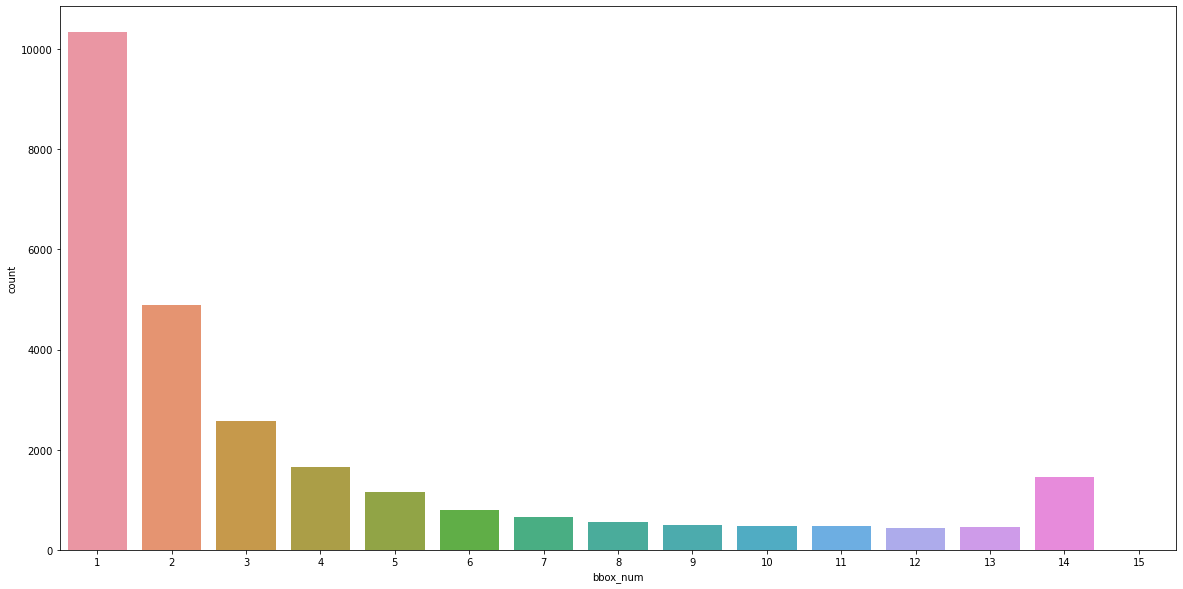

In [101]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
obj_num_in_img = pd.DataFrame(image_counter)
obj_num_in_img.columns = ['image_id', 'bbox_num']
sns.countplot(x='bbox_num', data=obj_num_in_img)